# Полная информация о покупателях (olist_public_dataset_v2.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
from pydantic import ValidationError
from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_NOTEBOOK_DIR, RAW_DIR
import olist_churn_prediction
from olist_churn_prediction import feature_processing

In [3]:
public_data = pd.read_csv(RAW_DIR / "olist_public_dataset_v2.csv", low_memory=False)

Почти все преобразования будут одинаковыми для датасетов olist_public_dataset_v2 и olist_classified_public_dataset, так как датасет с метками является выборкой из основного.

In [4]:
display(public_data.head())
public_data.shape

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01.000000,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,...,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,1,2017-09-09 19:52:54.000000,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,...,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,1,2017-01-30 17:00:09.000000,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,...,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,1,2018-03-11 18:18:36.000000,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,...,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,1,2017-04-20 08:01:08.000000,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,...,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


(100000, 25)

In [5]:
public_data.dtypes

order_id                          object
order_status                      object
order_products_value             float64
order_freight_value              float64
order_items_qty                    int64
order_sellers_qty                  int64
order_purchase_timestamp          object
order_aproved_at                  object
order_estimated_delivery_date     object
order_delivered_customer_date     object
customer_id                       object
customer_city                     object
customer_state                    object
customer_zip_code_prefix           int64
product_category_name             object
product_name_lenght                int64
product_description_lenght         int64
product_photos_qty                 int64
product_id                        object
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_ti

#### Пояснения к признакам:
1. `order_id` - id заказа;
2. `order_status` - статус заказа;
3. `order_products_value` - суммарная стоимость товаров в заказе;
4. `order_freight_value` - стоимость доставки;
5. `order_items_qty` - количество товаров в заказе;
6. `order_sellers_qty` - неясно, пояснений от заказчика нет, лучше удалить;
7. `order_purchase_timestamp` - время покупки;
8. `order_aproved_at` - время подтверждения заказа;
9. `order_estimated_delivery_date` - ожидаемая дата доставки;
10. `order_delivered_customer_date` - время доставки;
11. `customer_id` - id покупателя;
12. `customer_city` - город покупателя;
13. `customer_state` - штат (регион) покупателя;
14. `customer_zip_code_prefix` - число принадлежности к определенному региону для покупателя (аналог почтового индекса);
15. `product_id` - id товара;
16. `product_category_name` - название категории товара;
17. `product_name_lenght` - длина названия товара в символах;
18. `product_description_lenght` - длина описания товара в символах;
19. `product_photos_qty` - количество фото товара;
20. `review_id` - id обзора на товар; 
21. `review_score` - оценка товара по пятибальной шкале;
22. `review_comment_title` - все значения NaN, удалить;
23. `review_comment_message` - обзор на товар;
24. `review_creation_date` - дата создания анкеты для пользователя с целью оценить качество услуг;
25. `review_answer_timestamp` - дата ответа пользователем на анкету;

In [6]:
df = public_data.copy()

In [7]:
df = df.drop('order_sellers_qty', axis=1)

In [8]:
texts = ['review_comment_message', 'review_comment_title']
ids = ['order_id', 'customer_id', 'product_id', 'review_id']
time_features = ['order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date',
                 'order_delivered_customer_date', 'review_creation_date', 'review_answer_timestamp']
categorical_features = df.select_dtypes(include=["object"]).columns.drop(texts).drop(ids).drop(time_features).tolist()
numeric_features = df.select_dtypes(include=["int", "float"]).columns.tolist()

In [9]:
display(df[time_features].head())

,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,review_creation_date,review_answer_timestamp
0,2017-01-31 17:19:01.000000,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,2017-09-09 19:52:54.000000,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,2017-01-30 17:00:09.000000,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,2018-03-11 18:18:36.000000,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,2017-04-20 08:01:08.000000,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


In [26]:
print(categorical_features)

['order_status', 'customer_city', 'customer_state', 'product_category_name']


In [27]:
print(df.isna().sum())

order_id                             0
order_status                         0
order_products_value                 0
order_freight_value                  0
order_items_qty                      0
order_purchase_timestamp             0
order_aproved_at                    18
order_estimated_delivery_date        0
order_delivered_customer_date     2405
customer_id                          0
customer_city                        0
customer_state                       0
customer_zip_code_prefix             0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty                   0
product_id                           0
review_id                            0
review_score                         0
review_comment_title             91738
review_comment_message           57511
review_creation_date                 0
review_answer_timestamp              0
dtype: int64


Признаки `review_comment_title` и `review_comment_message` могут нести полезную информацию при правильной обработке, но имеют слишком много пропущенных значений. Даже если мы сможем получить хорошие классовые метки для 9 тысяч значений, то остальные 91 тысяча не будут иметь никакой метки. Решено удалить; если будет меньше пропусков, то можно вернуться к анализу этих признаков.

Пропуски в признаке `order_delivery_customer_date` являются следствием еще не доставленных заказов. Удалим, так как нас интересует в первую очередь удовлетворенность покупателей заказом, а здесь эта информация отсутствует. Пропуски в `order_aproved_at` спишем на аномалию и тоже удалим.

In [28]:
df.shape

(100000, 24)

In [29]:
df = df.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [30]:
df = df.dropna()

In [31]:
df.shape

(97578, 22)

## Временные признаки

In [32]:
display(df[time_features].head())
df[time_features].dtypes

,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,review_creation_date,review_answer_timestamp
0,2017-01-31 17:19:01.000000,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,2017-09-09 19:52:54.000000,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,2017-01-30 17:00:09.000000,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,2018-03-11 18:18:36.000000,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,2017-04-20 08:01:08.000000,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


order_purchase_timestamp         object
order_aproved_at                 object
order_estimated_delivery_date    object
order_delivered_customer_date    object
review_creation_date             object
review_answer_timestamp          object
dtype: object

Уберем часовой пояс с признаков и приведем к datetime:

In [54]:
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp']).dt.tz_localize(None)

In [51]:
for col in df[time_features].columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S.%f')

In [55]:
df[time_features].dtypes

order_purchase_timestamp         datetime64[ns]
order_aproved_at                 datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object

In [56]:
display(df[time_features].head())
df[time_features].dtypes

,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,review_creation_date,review_answer_timestamp
0,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,2017-02-07,2017-02-09 02:37:37
1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,2017-09-14,2017-09-15 03:43:47
2,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,2017-02-07,2017-02-10 14:18:53
3,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,2018-04-04,2018-04-05 02:52:31
4,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,2017-05-05,2017-05-08 15:20:18


order_purchase_timestamp         datetime64[ns]
order_aproved_at                 datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object

In [57]:
def datetime_summary(df: pd.DataFrame, cols: list[str] | None = None, as_days: bool = True) -> pd.DataFrame:
    stats = []
    for c in cols:
        col_min = df[c].min()
        col_max = df[c].max()
        delta = col_max - col_min
        if as_days:
            delta = delta / pd.Timedelta(days=1)  # float in days
        stats.append({"feature": c,
                      "min": col_min,
                      "max": col_max,
                      "range": delta})

    return pd.DataFrame(stats).sort_values("feature", ignore_index=True)

In [58]:
datetime_summary(df, time_features, True)

,feature,min,max,range
0,order_aproved_at,2016-09-15 12:16:38.000000,2018-09-28 11:05:22.374345,742.950514
1,order_delivered_customer_date,2016-10-11 13:46:32.082168,2018-10-03 03:46:34.717514,721.583364
2,order_estimated_delivery_date,2016-10-04 00:00:00.000000,2018-12-13 00:00:00.000000,800.000000
3,order_purchase_timestamp,2016-09-05 00:15:33.000000,2018-09-28 10:54:31.000000,753.443727
4,review_answer_timestamp,2016-10-07 21:32:28.000000,2018-10-03 12:54:08.000000,725.640046
5,review_creation_date,2016-10-06 00:00:00.000000,2018-10-03 00:00:00.000000,727.000000


Имеем следующую информацию о временных признаках:
1. Первое значение в датасете датируется 5 сентября 2016 года, а последнее - 13 декабря 2018 года.
2. Имеем данные за промежуток примерно 2 года и 4 месяца.

## Категориальные признаки

In [59]:
feature_processing.lowercase_categoricals(df, cat_cols=categorical_features, inplace=True)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,...,customer_zip_code_prefix,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,297dcf281305aabfee256d313076af2b,...,832,beleza_saude,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,2017-02-07,2017-02-09 02:37:37
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,b7563d94162ed0aa3f8d9cada4bcc536,...,384,informatica_acessorios,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,2017-09-14,2017-09-15 03:43:47
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,f102cb15ec41ca30fa2902da06495f6b,...,66,automotivo,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,2017-02-07,2017-02-10 14:18:53
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,e33c250311160298e5b457ca52720a35,...,743,cama_mesa_banho,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,2018-04-04,2018-04-05 02:52:31
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,8a8f7c9a4450f17ba3ee25a5ba821bc7,...,511,moveis_decoracao,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,2017-05-05,2017-05-08 15:20:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5e0fb4a48b36946c8121f9e03964d9c2,delivered,198.00,91.98,2,2017-10-02 20:19:43,2017-10-04 02:43:52.408623,2017-10-31,2017-10-11 16:25:47.945541,7f766d0e6f6e88fdd132d1d84567ccd8,...,478,ferramentas_jardim,36,450,1,08574b074924071f4e201e151b152b4e,5e0fb4a48b36946c8121f9e03964d9c2,5,2017-10-12,2017-10-12 19:53:25
99996,138d22c05c5e456f19bdc7dcf09b89aa,delivered,59.00,11.02,1,2017-03-22 06:13:55,2017-03-22 06:13:55.000000,2017-04-10,2017-03-31 13:23:12.316309,7b3f5e33cc06406a59d69da8df6494e0,...,61,telefonia,26,119,1,0cf573090c66bb30ac5e53c82bdb0403,138d22c05c5e456f19bdc7dcf09b89aa,5,2017-04-01,2017-04-04 04:42:58
99997,a97f1478d7e7648bf5bd2af02d1392a7,delivered,119.99,18.09,1,2017-06-10 20:12:12,2017-06-10 21:32:48.260831,2017-07-05,2017-06-24 07:26:42.947365,08e2db9881334685b0bbf25294a20a7f,...,132,esporte_lazer,42,660,1,14555ba663de8689feacf1d0819cc3b3,a97f1478d7e7648bf5bd2af02d1392a7,5,2017-06-25,2017-06-27 22:11:50
99998,7212b1926de631a35211dd5b4bd9d77b,delivered,119.99,18.09,1,2017-09-12 10:24:08,2017-09-12 10:35:15.542788,2017-10-02,2017-09-19 22:51:55.417806,019bfa3baf53d66e77de2c1f26d98cdb,...,394,cool_stuff,33,659,1,cfd652b39b87b4e06cf4ea106a32db47,7212b1926de631a35211dd5b4bd9d77b,1,2017-09-20,2017-09-25 21:22:57


In [60]:
display(df[categorical_features].head())
df[categorical_features].dtypes

,order_status,customer_city,customer_state,product_category_name
0,delivered,guaratuba,pr,beleza_saude
1,delivered,uberlandia,mg,informatica_acessorios
2,delivered,itapevi,sp,automotivo
3,delivered,goiania,go,cama_mesa_banho
4,delivered,recife,pe,moveis_decoracao


order_status             object
customer_city            object
customer_state           object
product_category_name    object
dtype: object

In [61]:
city_state_counts = (
    df
    .groupby('customer_city')['customer_state']
    .nunique()
)

conflict_cities = city_state_counts[city_state_counts > 1]

print(f"Количество «проблемных» городов: {len(conflict_cities)}")

Количество «проблемных» городов: 160


In [62]:
# все строки, где customer_city входит в список «конфликтных»
conflicts_df = (df
                .loc[df['customer_city'].isin(conflict_cities.index),
                        ['customer_city', 'customer_state']]
                .drop_duplicates()
                .sort_values(['customer_city', 'customer_state']))
print(conflicts_df)

        customer_city customer_state
81681     agua_branca             al
52379     agua_branca             pb
55512     agua_branca             pi
59608     alto_alegre             pr
13732     alto_alegre             rr
...               ...            ...
94307          vicosa             rn
107           vitoria             es
86150         vitoria             pr
97694  wenceslau_braz             mg
2594   wenceslau_braz             pr

[350 rows x 2 columns]


In [63]:
feature_processing.disambiguate_city_state(df, city_col="customer_city", state_col="customer_state", inplace=True)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,...,customer_zip_code_prefix,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,297dcf281305aabfee256d313076af2b,...,832,beleza_saude,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,2017-02-07,2017-02-09 02:37:37
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,b7563d94162ed0aa3f8d9cada4bcc536,...,384,informatica_acessorios,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,2017-09-14,2017-09-15 03:43:47
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,f102cb15ec41ca30fa2902da06495f6b,...,66,automotivo,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,2017-02-07,2017-02-10 14:18:53
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,e33c250311160298e5b457ca52720a35,...,743,cama_mesa_banho,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,2018-04-04,2018-04-05 02:52:31
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,8a8f7c9a4450f17ba3ee25a5ba821bc7,...,511,moveis_decoracao,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,2017-05-05,2017-05-08 15:20:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5e0fb4a48b36946c8121f9e03964d9c2,delivered,198.00,91.98,2,2017-10-02 20:19:43,2017-10-04 02:43:52.408623,2017-10-31,2017-10-11 16:25:47.945541,7f766d0e6f6e88fdd132d1d84567ccd8,...,478,ferramentas_jardim,36,450,1,08574b074924071f4e201e151b152b4e,5e0fb4a48b36946c8121f9e03964d9c2,5,2017-10-12,2017-10-12 19:53:25
99996,138d22c05c5e456f19bdc7dcf09b89aa,delivered,59.00,11.02,1,2017-03-22 06:13:55,2017-03-22 06:13:55.000000,2017-04-10,2017-03-31 13:23:12.316309,7b3f5e33cc06406a59d69da8df6494e0,...,61,telefonia,26,119,1,0cf573090c66bb30ac5e53c82bdb0403,138d22c05c5e456f19bdc7dcf09b89aa,5,2017-04-01,2017-04-04 04:42:58
99997,a97f1478d7e7648bf5bd2af02d1392a7,delivered,119.99,18.09,1,2017-06-10 20:12:12,2017-06-10 21:32:48.260831,2017-07-05,2017-06-24 07:26:42.947365,08e2db9881334685b0bbf25294a20a7f,...,132,esporte_lazer,42,660,1,14555ba663de8689feacf1d0819cc3b3,a97f1478d7e7648bf5bd2af02d1392a7,5,2017-06-25,2017-06-27 22:11:50
99998,7212b1926de631a35211dd5b4bd9d77b,delivered,119.99,18.09,1,2017-09-12 10:24:08,2017-09-12 10:35:15.542788,2017-10-02,2017-09-19 22:51:55.417806,019bfa3baf53d66e77de2c1f26d98cdb,...,394,cool_stuff,33,659,1,cfd652b39b87b4e06cf4ea106a32db47,7212b1926de631a35211dd5b4bd9d77b,1,2017-09-20,2017-09-25 21:22:57


In [64]:
city_state_counts = (
    df
    .groupby('customer_city')['customer_state']
    .nunique()
)

conflict_cities = city_state_counts[city_state_counts > 1]

print(f"Количество «проблемных» городов: {len(conflict_cities)}")

Количество «проблемных» городов: 0


In [65]:
for col in categorical_features:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print()

--- order_status ---
order_status
delivered    97569
canceled         9
Name: count, dtype: int64

--- customer_city ---
customer_city
sao_paulo         14856
rio_de_janeiro     6899
belo_horizonte     2678
brasilia           1994
curitiba           1454
                  ...  
macambira             1
carira                1
bertopolis            1
lunardelli            1
ilha_do_mel           1
Name: count, Length: 4288, dtype: int64

--- customer_state ---
customer_state
sp    40071
rj    13034
mg    11751
rs     5492
pr     4943
sc     3667
ba     3347
es     2005
df     2003
go     1949
pe     1580
ce     1283
pa      999
mt      902
ma      735
ms      713
pb      524
rn      514
pi      430
al      423
se      331
ro      281
to      253
am      154
ac       86
ap       66
rr       42
Name: count, dtype: int64

--- product_category_name ---
product_category_name
cama_mesa_banho                       10267
beleza_saude                           7754
esporte_lazer                  

Лишь 9 значений признака `order_status` из 97578 помечены как canceled, остальные - delivered. Уберем признак из-за малой информативности.

In [66]:
df = df.drop('order_status', axis=1)

In [67]:
translation = pd.read_csv(RAW_DIR / "product_category_name_translation.csv", low_memory=False)

In [68]:
display(translation.head())

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [69]:
df = df.merge(translation, how='left', on='product_category_name')

In [70]:
df = df.drop('product_category_name', axis=1)

In [71]:
display(df.head())

,order_id,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_city,...,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_creation_date,review_answer_timestamp,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,349.90,13.84,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,297dcf281305aabfee256d313076af2b,guaratuba,...,832,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,2017-02-07,2017-02-09 02:37:37,health_beauty
1,59af46052a799e80e2f0c665c587731d,15.00,15.10,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,b7563d94162ed0aa3f8d9cada4bcc536,uberlandia,...,384,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,2017-09-14,2017-09-15 03:43:47,computers_accessories
2,a3e6136894621db402a772c6bc72a12a,238.90,18.00,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,f102cb15ec41ca30fa2902da06495f6b,itapevi,...,66,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,2017-02-07,2017-02-10 14:18:53,auto
3,b675ea5a618922f6e679e30531b8957b,29.99,18.23,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,e33c250311160298e5b457ca52720a35,goiania,...,743,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,2018-04-04,2018-04-05 02:52:31,bed_bath_table
4,195a8be6794c487fe6cfbb97b7c61902,295.99,47.65,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,8a8f7c9a4450f17ba3ee25a5ba821bc7,recife,...,511,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,2017-05-05,2017-05-08 15:20:18,furniture_decor


## Численные признаки

In [72]:
display(df[numeric_features].head())

,order_products_value,order_freight_value,order_items_qty,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,review_score
0,349.90,13.84,1,832,51,625,1,5
1,15.00,15.10,1,384,44,1428,2,5
2,238.90,18.00,1,66,55,637,1,5
3,29.99,18.23,1,743,55,617,1,4
4,295.99,47.65,1,511,49,558,2,5


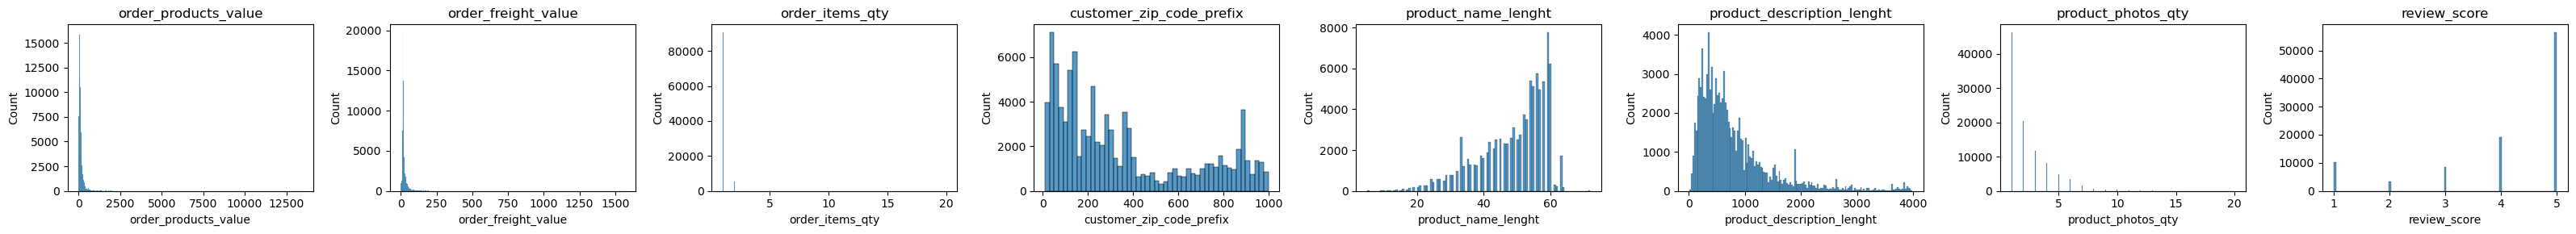

In [73]:
n = len(numeric_features)

# Настройка размера фигуры (важно для плотности)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 3))  # один ряд, n колонок

for i, col in enumerate(numeric_features):
    sns.histplot(data=df, x=col, ax=axes[i], kde=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [46]:
print(df['order_products_value'].sort_values().head()) # проверка на заказы с нулевой стоимостью

76423    2.29
14570    2.50
25532    2.90
91193    2.99
5789     2.99
Name: order_products_value, dtype: float32


In [47]:
print(df['order_freight_value'].sort_values().head()) # проверка на размеры комиссии за доставку
print(df['order_freight_value'].sort_values().tail())

35893    0.0
67273    0.0
93989    0.0
19862    0.0
52671    0.0
Name: order_freight_value, dtype: float32
2793      479.279999
52538     488.820007
79662     533.609985
18300     687.960022
4355     1562.099976
Name: order_freight_value, dtype: float32


In [48]:
print(df['order_items_qty'].sort_values().head()) # проверка на количество=0 заказанных товаров
print(df['order_items_qty'].sort_values().tail())

0     1
33    1
34    1
35    1
36    1
Name: order_items_qty, dtype: Int64
30126    15
27985    15
48561    20
16792    20
10166    20
Name: order_items_qty, dtype: Int64


In [49]:
set(df.columns) - set(public_data.columns)

{'product_category_name_english'}

In [50]:
set(public_data.columns) - set(df.columns)

{'order_sellers_qty',
 'order_status',
 'product_category_name',
 'review_comment_message',
 'review_comment_title'}

In [51]:
df.to_parquet(INTERIM_NOTEBOOK_DIR / "public_data_interim.parquet", index=False)